##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Addons Optimizers: ConditionalGradient

### TBD!!!!!! to modify the ref link

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1UT4e-BZkpdsavgLXUpsCN5KEpAB3NY_b#scrollTo=b5P4BEg1XYd5"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pkan2/addons/blob/master/docs/tutorials/optimizers_conditionalgradient.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Overview
This notebook will demonstrate how to use the Conditional Graident Optimizer from the Addons package.

# ConditionalGradient

> Condtitional Gradient Optimizer provides an alternative method for handling regularizer in the optimization process. The implementation of this optimizer is based on the following paper:
https://arxiv.org/pdf/1803.06453.pdf. Current implementation enforces Frobenius norm constraints on a model. The variable update rule being implemented is:
$variable -= (1 - learning\_rate) \times (variable + lambda\_ \times \frac{gradient}{  frobenius\_norm(gradient) + epsilon})$, 
where, 'learning_rate' and 'lambda\_' are the parameters that are needed to input into the model when initializing the model. And 'epsilon' is a constant, which is relatively small as compared to the norm of gradient. The purpose of 'epsilon' here is to handle the case of undefined mathematic operation to divided by zero, when the norm of gradient equals zero.


## Setup

In [0]:
!pip install tensorflow-gpu==2.0.0rc0
!pip install tfa-nightly
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# Hyperparameters
batch_size=64
epochs=10

# Build the Model

In [0]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu', name='dense_1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(10, activation='softmax', name='predictions'),
])

# Prep the Data

In [5]:
# Load MNIST dataset as NumPy arrays
dataset = {}
num_validation = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 784).astype('float32') / 255
x_test = x_test.reshape(-1, 784).astype('float32') / 255

11493376/11490434 [==============================] - 0s 0us/step


# Define a Custom Callback Function

In [0]:
# This function is to calculate the frobenius norm of the matrix of all
# layer's weight.
# args:
#      m: is a list of weights param for each layers
def frobenius_norm(m):
    total_reduce_sum = 0
    for i in range(len(m)):
        total_reduce_sum = total_reduce_sum + tf.math.reduce_sum(m[i]**2)
    norm = total_reduce_sum**0.5
    return norm

In [0]:
CG_frobenius_norm_of_weight = []
CG_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: CG_frobenius_norm_of_weight.append(
        frobenius_norm(model_1.trainable_weights).numpy()))

# Train and Evaluate

Simply replace typical keras optimizers with the new tfa optimizer 

In [8]:
# Compile the model
model_1.compile(
    optimizer=tfa.optimizers.ConditionalGradient(
        learning_rate=0.99949, lambda_=203),  # Utilize TFA optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history_1 = model_1.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=epochs,
    callbacks=[CG_get_weight_norm])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.3826 - accuracy: 0.8842 - val_loss: 0.2034 - val_accuracy: 0.9395
Epoch 2/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1930 - accuracy: 0.9427 - val_loss: 0.1642 - val_accuracy: 0.9490
Epoch 3/10
60000/60000 [==============================] - 4s 67us/sample - loss: 0.1532 - accuracy: 0.9548 - val_loss: 0.1349 - val_accuracy: 0.9621
Epoch 4/10
60000/60000 [==============================] - 4s 67us/sample - loss: 0.1320 - accuracy: 0.9600 - val_loss: 0.1107 - val_accuracy: 0.9669
Epoch 5/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1251 - accuracy: 0.9629 - val_loss: 0.1482 - val_accuracy: 0.9534
Epoch 6/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1178 - accuracy: 0.9645 - val_loss: 0.1068 - val_accuracy: 0.9683
Epoch 7/10
60000/60000 [==============================] 

In [0]:

# TBD: shall we delete this block? It seems like this block does not mean much 
#      for our demo here?


# Evaluate the network
print('Evaluate on test data:')
results = model_1.evaluate(x_test, y_test, batch_size=128)
print('Test loss = {0}, Test acc: {1}'.format(results[0], results[1]))

# Comparision with the Performance of SGD

In [0]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(
        64, input_shape=(784, ), activation='relu', name='dense_1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(10, activation='softmax', name='predictions'),
])

In [0]:
SGD_frobenius_norm_of_weight = []
SGD_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: SGD_frobenius_norm_of_weight.append(
        frobenius_norm(model_2.trainable_weights).numpy()))

In [11]:
# Compile the model

model_2.compile(
    optimizer=tf.keras.optimizers.SGD(0.1),  # Utilize TFA optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history_2 = model_2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=epochs,
    callbacks=[SGD_get_weight_norm])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3569 - accuracy: 0.8954 - val_loss: 0.1840 - val_accuracy: 0.9434
Epoch 2/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.1603 - accuracy: 0.9531 - val_loss: 0.1269 - val_accuracy: 0.9617
Epoch 3/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.1193 - accuracy: 0.9635 - val_loss: 0.1213 - val_accuracy: 0.9630
Epoch 4/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0957 - accuracy: 0.9712 - val_loss: 0.0968 - val_accuracy: 0.9710
Epoch 5/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0799 - accuracy: 0.9761 - val_loss: 0.0973 - val_accuracy: 0.9682
Epoch 6/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0702 - accuracy: 0.9786 - val_loss: 0.0882 - val_accuracy: 0.9716
Epoch 7/10
60000/60000 [==============================] 

In [0]:
# TBD: shall we delete this block? It seems like this block does not mean much 
#      for our demo here?




# Evaluate the network
print('Evaluate on test data:')
results = model_2.evaluate(x_test, y_test, batch_size=128)
print('Test loss = {0}, Test acc: {1}'.format(results[0], results[1]))

# Plot the Comparison Graph

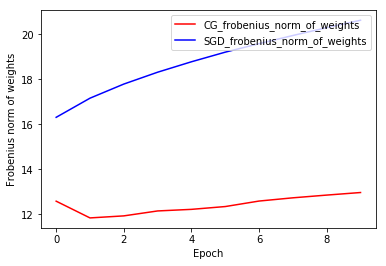

In [12]:
plt.plot(
    CG_frobenius_norm_of_weight,
    color='r',
    label='CG_frobenius_norm_of_weights')
plt.plot(
    SGD_frobenius_norm_of_weight,
    color='b',
    label='SGD_frobenius_norm_of_weights')
plt.xlabel('Epoch')
plt.ylabel('Frobenius norm of weights')
plt.legend(loc=1)